In [1]:
# import ocw.plotter as oplt
import importlib
import datetime
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from letkf_forecasting import analyse_results, letkf_io
# import seaborn as sns
# cpal = sns.color_palette()
# sns.set_style('whitegrid')
# sns.set_context('paper', font_scale=1.0,
#                 rc={'lines.linewidth':1.0,
#                     'lines.markersize':7})

In [2]:
%matplotlib inline

# Print Errors & Generate TaylorDiagram

In [3]:
import seaborn as sns
cpal = sns.color_palette()

In [4]:
class TaylorDiagram(object):
    """Taylor diagram: plot model standard deviation and correlation
    to reference (data) sample in a single-quadrant polar plot, with
    r=stddev and theta=arccos(correlation).
    """

    def __init__(self, refstd, norm=False, fig=None, rect=111, label='_'):
        """Set up Taylor diagram axes, i.e. single quadrant polar
        plot, using mpl_toolkits.axisartist.floating_axes. refstd is
        the reference standard deviation to be compared to.
        """

        from matplotlib.projections import PolarAxes
        import mpl_toolkits.axisartist.floating_axes as FA
        import mpl_toolkits.axisartist.grid_finder as GF

        self.refstd = refstd            # Reference standard deviation
        self.std = refstd
        if norm:
            self.refstd = 1.0
            self.std = refstd
        self.norm = norm
        tr = PolarAxes.PolarTransform()

        # Correlation labels
        rlocs = np.concatenate((np.arange(5)/5.,[0.95,0.99]))
        tlocs = np.arccos(rlocs)        # Conversion to polar angles
        gl1 = GF.FixedLocator(tlocs)    # Positions
        tf1 = GF.DictFormatter(dict(zip(tlocs, map(str,rlocs))))

        # Standard deviation axis extent
        self.smin = 0
        self.smax = 2*self.refstd
        gl2 = GF.MaxNLocator(5)


        ghelper = FA.GridHelperCurveLinear(tr,
                                           extremes=(0, np.pi/2, # 1st quadrant
                                                     self.smin,self.smax),
                                           grid_locator1=gl1,
                                           grid_locator2=gl2,
                                           tick_formatter1=tf1,
                                           tick_formatter2=None
                                           )

        if fig is None:
            fig = plt.figure()

        ax = FA.FloatingSubplot(fig, rect, grid_helper=ghelper)
        fig.add_subplot(ax)

        # Adjust axes
        ax.axis["top"].set_axis_direction("bottom")  # "Angle axis"
        ax.axis["top"].toggle(ticklabels=True, label=True, ticks=True)
        ax.axis["top"].major_ticklabels.set_axis_direction("top")
        ax.axis["top"].label.set_axis_direction("top")
        ax.axis["top"].label.set_text("Correlation")

        ax.axis["left"].set_axis_direction("bottom") # "X axis"
        #ax.axis["left"].major_ticklabels.set_rotation(25)
        ax.axis["left"].label.set_text("Standard Deviation")
        #ax.axis["left"].label.update_bbox_position_size((1.3,1.0))


        ax.axis["right"].set_axis_direction("top")   # "Y axis"
        ax.axis["right"].toggle(ticklabels=True, label=True)
        ax.axis["right"].major_ticklabels.set_axis_direction("left")
        ax.axis["right"].label.set_text("Standard Deviation")

        ax.axis["bottom"].set_visible(False)         # Useless
        
        # Contours along standard deviations
        ax.grid(True)
        #ax.get_aux_axes(tr).grid(True)
        self._ax = ax                   # Graphical axes
        self.ax = ax.get_aux_axes(tr)   # Polar coordinates
        
        #self.ax.patch = ax.patch # for aux_ax to have a clip path as in ax
        ax.patch.zorder = 0.9

        # Add reference point and stddev contour
        print("Reference std:", self.refstd)
        l, = self.ax.plot([0], self.refstd, 'k*',
                          ls='', ms=10, label=label, zorder=3)
        t = np.linspace(0, np.pi/2)
        r = np.zeros_like(t) + self.refstd
        self.ax.plot(t,r, 'k--', label='_', zorder=3, alpha=0.6)

        # Collect sample points for latter use (e.g. legend)
        self.samplePoints = [l]

    def add_sample(self, stddev, corrcoef, *args, **kwargs):
        """Add sample (stddev,corrcoeff) to the Taylor diagram. args
        and kwargs are directly propagated to the Figure.plot
        command."""
        
        if self.norm:
            stddev = stddev*1.0/self.std
        l, = self.ax.plot(np.arccos(corrcoef), stddev, zorder=5,
                          *args, **kwargs) # (theta,radius)
        self.samplePoints.append(l)

        return l

    def add_contours(self, levels=5, **kwargs):
        """Add constant centered RMS difference contours."""

        rs,ts = np.meshgrid(np.linspace(self.smin,self.smax),
                            np.linspace(0, np.pi/2))
        # Compute centered RMS difference
        rms = np.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*np.cos(ts))
        
        contours = self.ax.contour(ts, rs, rms, levels, zorder=4, **kwargs)
        self.ax.clabel(contours, inline=1, **kwargs)
        return contours
    
    def add_skill_contour(self, rms_val, **kwargs):
        rs,ts = np.meshgrid(np.linspace(self.smin,self.smax),
                            np.linspace(0, np.pi/2))
        # Compute centered RMS difference
        rms = np.sqrt(self.refstd**2 + rs**2 - 2*self.refstd*rs*np.cos(ts))
        
        contours = self.ax.contour(ts, rs, rms, rms_vals, **kwargs)

        return contours
    
    def add_corr_line(self, cor, **kwargs):
        acos = np.arccos(cor)
        line = self.ax.plot([0,acos], [0, self.smax], **kwargs)
        return line

In [5]:
def generate_taylor(returned, runs, normalized=True):
    fig = plt.figure(dpi=300)
    if normalized:
        sd_t = 1
        sd_t_array = returned[1]['truth_sd'].values.ravel()
    else:
        sd_t = returned[1]['truth_sd'].mean().item()
        sd_t_array = np.ones_like(returned[1]['truth_sd'].values.ravel())

    dia = TaylorDiagram(sd_t, norm=False, fig=fig, label='Observations')
    count = 0
    for run in runs:
        color = cpal[count]
        dia.add_sample(returned[count]['forecast_sd'].values.ravel()/sd_t_array,
                       returned[count]['correlation'].values.ravel(),
                       color=color, label=run + '_line')
        count += 1
#         dia.add_sample(sd_wrf.values.ravel(), corr_wrf.values.ravel(),
#                        color=cpal[2], label='wrf_line')

    horizons = [15, 30, 45, 60]
    marks = ['o', '^', 'd', 's']
    hor_count = 0
    for hor in horizons:
        count = 0
        for run in runs:
            color = cpal[count]
            mark = marks[hor_count]
            dia.add_sample(returned[count]['forecast_sd'].loc[hor]/sd_t_array[hor_count],
                           returned[count]['correlation'].loc[hor],
                           color=color, label=run, marker=mark)
            count += 1
        hor_count += 1
    
    if not normalized:
        mcount = 0
        for hor in horizons:
            color = 'k'
            mark = marks[mcount]
            dia.add_sample(returned[1]['truth_sd'].loc[hor],
                           [1],
                           color=color, label=run, marker=mark)
            mcount += 1
#     hor = 15
#     mark = 'o'
#     dia.add_sample(sd_ow.loc[hor], corr_ow.loc[hor], label='ow', marker=mark, color=cpal[4])
#     dia.add_sample(sd_wrf.loc[hor], corr_wrf.loc[hor], label='wrf', marker=mark, color=cpal[2])

#     hor = 30
#     mark = '^'
#     dia.add_sample(sd_ow.loc[hor], corr_ow.loc[hor], label='ow', marker=mark, color=cpal[4])
#     dia.add_sample(sd_wrf.loc[hor], corr_wrf.loc[hor], label='wrf', marker=mark, color=cpal[2])

#     hor = 45
#     mark = 'd'
#     dia.add_sample(sd_ow.loc[hor], corr_ow.loc[hor], label='ow', marker=mark, color=cpal[4])
#     dia.add_sample(sd_wrf.loc[hor], corr_wrf.loc[hor], label='wrf', marker=mark, color=cpal[2])

#     hor = 60
#     mark = 's'
#     dia.add_sample(sd_ow.loc[hor], corr_ow.loc[hor], label='ow', marker=mark, color=cpal[4])
#     dia.add_sample(sd_wrf.loc[hor], corr_wrf.loc[hor], label='wrf', marker=mark, color=cpal[2])

    dia.add_contours(5, colors='k', alpha=0.25, fontsize=8)
    samplePoints = dia.samplePoints[0:len(runs) + 1]
    fig.legend(samplePoints, ['obs'] + runs)


In [6]:
# runs = ['opt_flow', 'wrf', 'wrf_no_div', 'ow_15', 'owp_opt', 'persistence']
runs = ['opt_flow', 'wrf_no_div', 'owp_opt', 'persistence']

In [7]:
directory_name = 'third_set_only_cloudy'
error_stats = []
for run in runs:
    load_directory = ('/a2/uaren/travis/'
                      + 'results/multi_day_error/'
                      + f'{directory_name}/{run}')
    adict = {'name': run}
    for stat_file in os.listdir(load_directory):
        stat_name = stat_file.split('.')[0]
        stat_file = os.path.join(load_directory,
                                 stat_file)
        adict[stat_name] = pd.read_hdf(stat_file)
    error_stats.append(adict)

In [8]:
name_list = [
    arun['name']
    for arun in error_stats]
persistence = error_stats[
    name_list.index('persistence')]

In [9]:
stat='forecast_sd'
this_legend = []
print(stat)
print(directory_name)
plt.figure()
for these_errors in error_stats:
    print(these_errors['name'])
    print(these_errors['truth_sd'], '\n')
    print(these_errors[stat], '\n')
#     increase = (these_errors[stat].values
#                 - these_errors['truth_sd'].values)
#     percent_increase = increase/np.abs(these_errors['truth_sd']) * 100
#     this_legend.append(legend_dict[these_errors['name']])
#     plt.plot(percent_increase, linestyle='--', marker='.')

# increase = (persistence[stat].values
#             - persistence['truth_sd'].values)
# percent_increase = increase/np.abs(persistence['truth_sd'])
# this_legend.append(legend_dict['persistence'])
# plt.plot(percent_increase, linestyle='--', marker='.')

# plt.title('Percent increase in standard deviation')
# plt.ylabel('Percent increase in standard deviation')
# plt.xlabel('Time horizon (min)')
# plt.legend(this_legend)

forecast_sd
third_set_only_cloudy
opt_flow
     true_sd
15  0.246628
30  0.244741
45  0.244291
60  0.242068 

          sd
15  0.242707
30  0.237561
45  0.234883
60  0.233000 

wrf_no_div
     true_sd
15  0.246628
30  0.244741
45  0.244291
60  0.242068 

          sd
15  0.236573
30  0.229552
45  0.227753
60  0.223017 

owp_opt
     true_sd
15  0.246628
30  0.244741
45  0.244291
60  0.242068 

          sd
15  0.238259
30  0.228624
45  0.223190
60  0.214038 

persistence
     true_sd
15  0.246628
30  0.244741
45  0.244291
60  0.242068 

          sd
15  0.245839
30  0.243818
45  0.242738
60  0.239155 



In [10]:
# improvements for rmse
stat='rmse'
print(stat)
print(directory_name)
for these_errors in error_stats:
    
    print(these_errors['name'] + '\n')
    
    print(these_errors[stat], '\n')
    
    if these_errors['name'] == 'persistence':
        continue
    print(these_errors['name'] + '\n')
    decrease = (persistence[stat]
                - these_errors[stat])
    percent_decrease = decrease/persistence[stat]
    print('Percent decrease')
    print(percent_decrease, '\n')
    skill_score = (1 - these_errors[stat]/persistence[stat]) * 100
    print('Skill Score')
    print(skill_score, '\n')

rmse
third_set_only_cloudy
opt_flow

        rmse
15  0.112790
30  0.133120
45  0.145324
60  0.152903 

opt_flow

Percent decrease
        rmse
15  0.209607
30  0.186246
45  0.168126
60  0.140966 

Skill Score
         rmse
15  20.960718
30  18.624617
45  16.812580
60  14.096567 

wrf_no_div

        rmse
15  0.117688
30  0.142077
45  0.147266
60  0.150150 

wrf_no_div

Percent decrease
        rmse
15  0.175279
30  0.131493
45  0.157012
60  0.156433 

Skill Score
         rmse
15  17.527870
30  13.149256
45  15.701213
60  15.643338 

owp_opt

        rmse
15  0.108417
30  0.123645
45  0.126810
60  0.131720 

owp_opt

Percent decrease
        rmse
15  0.240251
30  0.244163
45  0.274104
60  0.259978 

Skill Score
         rmse
15  24.025131
30  24.416319
45  27.410368
60  25.997819 

persistence

        rmse
15  0.142701
30  0.163587
45  0.174695
60  0.177994 



In [11]:
# improvements for correlation
stat = 'correlation'
print(stat)
print(directory_name, '\n')

for these_errors in error_stats:
    print(these_errors['name'] + '\n')
    
    print(these_errors[stat], '\n')
    
    if these_errors['name'] == 'persistence':
        continue
    increase = (these_errors[stat]
                - persistence[stat])
    percent_increase = (increase/np.abs(persistence[stat])) * 100
    print('Percent increase')
    print(percent_increase, '\n')

correlation
third_set_only_cloudy 

opt_flow

    correlation
15     0.858761
30     0.802498
45     0.763866
60     0.738753 

Percent increase
    correlation
15     3.199496
30     3.406359
45     2.766743
60     1.538203 

wrf_no_div

    correlation
15     0.843675
30     0.771566
45     0.755753
60     0.745690 

Percent increase
    correlation
15     1.386575
30    -0.579467
45     1.675197
60     2.491626 

owp_opt

    correlation
15     0.867627
30     0.825039
45     0.814493
60     0.797009 

Percent increase
    correlation
15     4.264909
30     6.310831
45     9.577918
60     9.545276 

persistence

    correlation
15     0.832137
30     0.776063
45     0.743301
60     0.727562 



In [12]:
legend_dict = {'opt_flow': 'Dense opt. flow',
               'persistence': 'Persistence',
               'radiosonde': 'Radiosonde',
               'wrf': 'WRF',
               'wrf_no_div': 'WRF no div.',
               'ow_15': 'WRF & opt. flow',
               'owp_opt': 'WRF, opt. flow, & wind pert.'}

rmse
third_set_only_cloudy


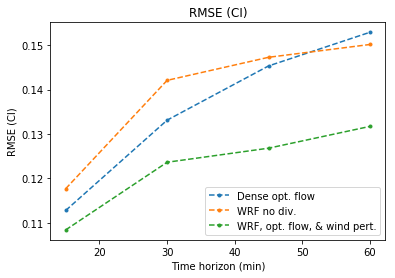

In [13]:
stat='rmse'
this_legend = []
print(stat)
print(directory_name)
plt.figure()
for these_errors in error_stats:
    if these_errors['name'] in ['persistence', 'radiosonde']:
        continue   
    this_legend.append(legend_dict[these_errors['name']])
    plt.plot(these_errors[stat], linestyle='--', marker='.')
plt.title('RMSE (CI)')
plt.ylabel('RMSE (CI)')
plt.xlabel('Time horizon (min)')
plt.legend(this_legend)
#     print('Percent decrease')
#     print(percent_decrease, '\n')

rmse
third_set_only_cloudy


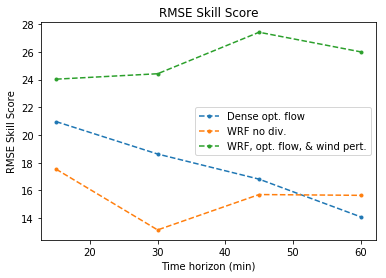

In [14]:
stat='rmse'
this_legend = []
print(stat)
print(directory_name)
plt.figure()
for these_errors in error_stats:
    if these_errors['name'] in ['persistence', 'radiosonde']:
        continue
    skill_score = (1 - these_errors[stat]/persistence[stat])*100    
    this_legend.append(legend_dict[these_errors['name']])
    plt.plot(skill_score, linestyle='--', marker='.')
plt.title('RMSE Skill Score')
plt.ylabel('RMSE Skill Score')
plt.xlabel('Time horizon (min)')
plt.legend(this_legend)
#     print('Percent decrease')
#     print(percent_decrease, '\n')

In [15]:
# stat='correlation'
# these_runs = []
# print(stat)
# print(directory_name)
# plt.figure()
# for these_errors in error_stats:
#     if these_errors['name'] == 'persistence':
#         continue
#     increase = (these_errors[stat]
#                 - persistence[stat])
#     percent_increase = increase/np.abs(persistence[stat])
#     these_runs.append(these_errors['name'])
#     plt.plot(percent_increase, linestyle='--', marker='.')
# plt.title('Percent increase of correlation (persistence as reference)')
# plt.ylabel('Correlation')
# plt.xlabel('Time horizon (min)')
# plt.legend(these_runs)
# #     print('Percent decrease')
# #     print(percent_decrease, '\n')

In [16]:
[this_errors['name'] for this_errors in error_stats]

['opt_flow', 'wrf_no_div', 'owp_opt', 'persistence']

forecast_sd
third_set_only_cloudy


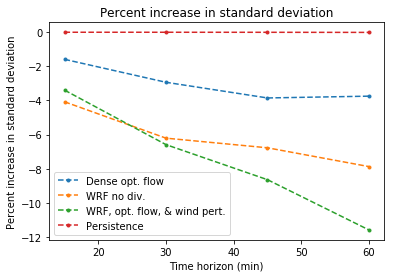

In [17]:
stat='forecast_sd'
marks = ['o', '^', 'd', 's']
this_legend = []
print(stat)
print(directory_name)
plt.figure()
for these_errors in error_stats:
    if these_errors['name'] in ['persistence', 'radiosonde']:
        continue
    increase = (these_errors[stat].values
                - these_errors['truth_sd'].values)
    percent_increase = increase/np.abs(these_errors['truth_sd']) * 100
    this_legend.append(legend_dict[these_errors['name']])
    plt.plot(percent_increase, linestyle='--', marker='.')

increase = (persistence[stat].values
            - persistence['truth_sd'].values)
percent_increase = increase/np.abs(persistence['truth_sd'])
this_legend.append(legend_dict['persistence'])
plt.plot(percent_increase, linestyle='--', marker='.')

plt.title('Percent increase in standard deviation')
plt.ylabel('Percent increase in standard deviation')
plt.xlabel('Time horizon (min)')
plt.legend(this_legend)

In [18]:
[legend_dict[arun] for arun in runs]

['Dense opt. flow',
 'WRF no div.',
 'WRF, opt. flow, & wind pert.',
 'Persistence']

third_set_only_cloudy
Reference std: 1


/home/travis/miniconda3/envs/letkf/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'fontsize'
  s)


(0.6, 1.1)

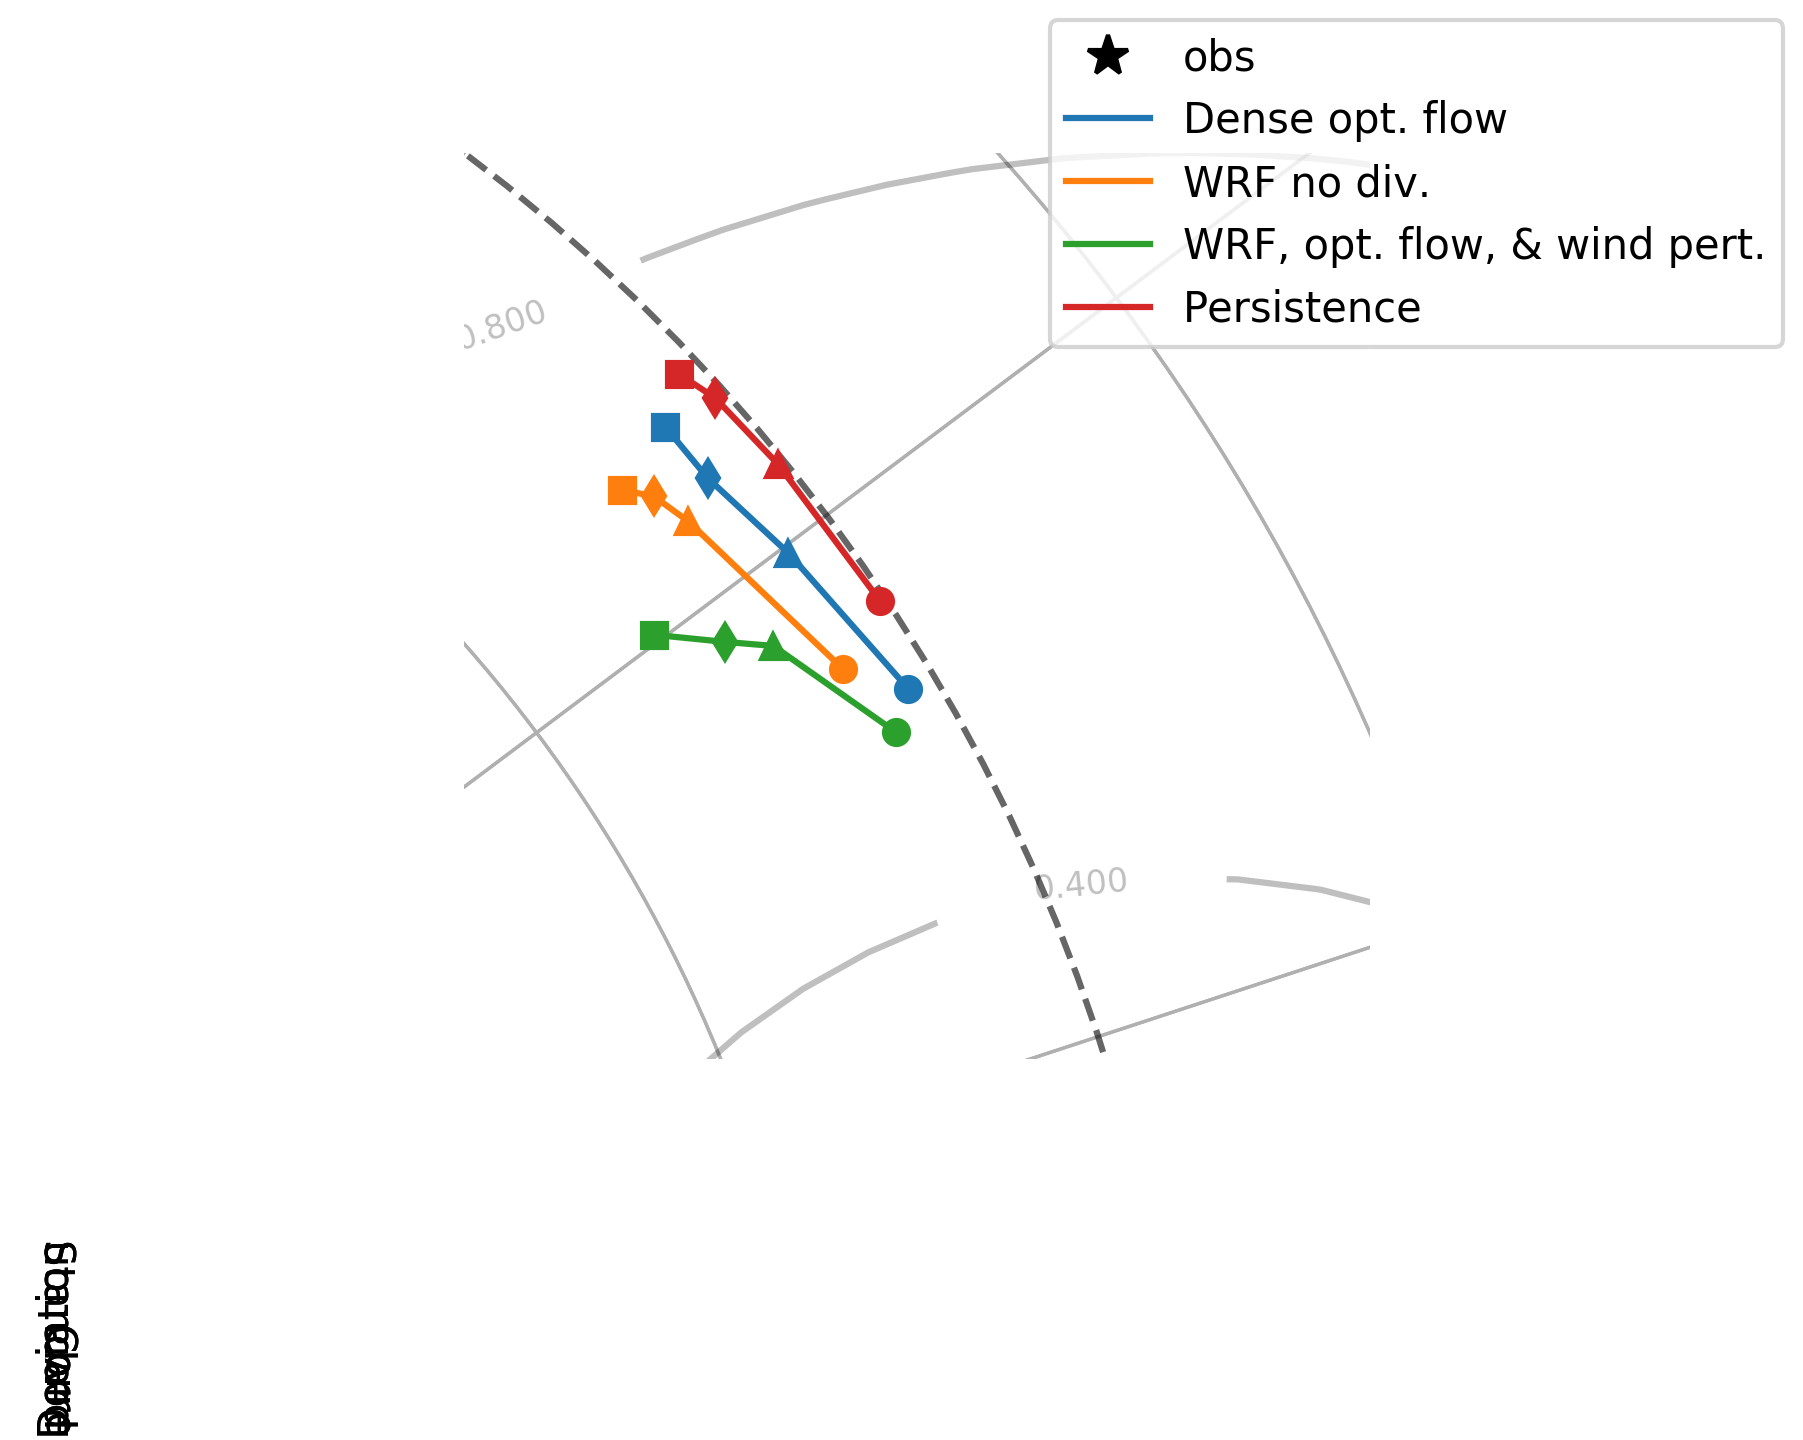

In [19]:
print(directory_name)
# this_error_stats = [e]
generate_taylor(error_stats, [legend_dict[arun] for arun in runs])
plt.ylim([.3, .8])
plt.xlim([.6, 1.1])

third_set_only_cloudy
Reference std: 1


/home/travis/miniconda3/envs/letkf/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'fontsize'
  s)


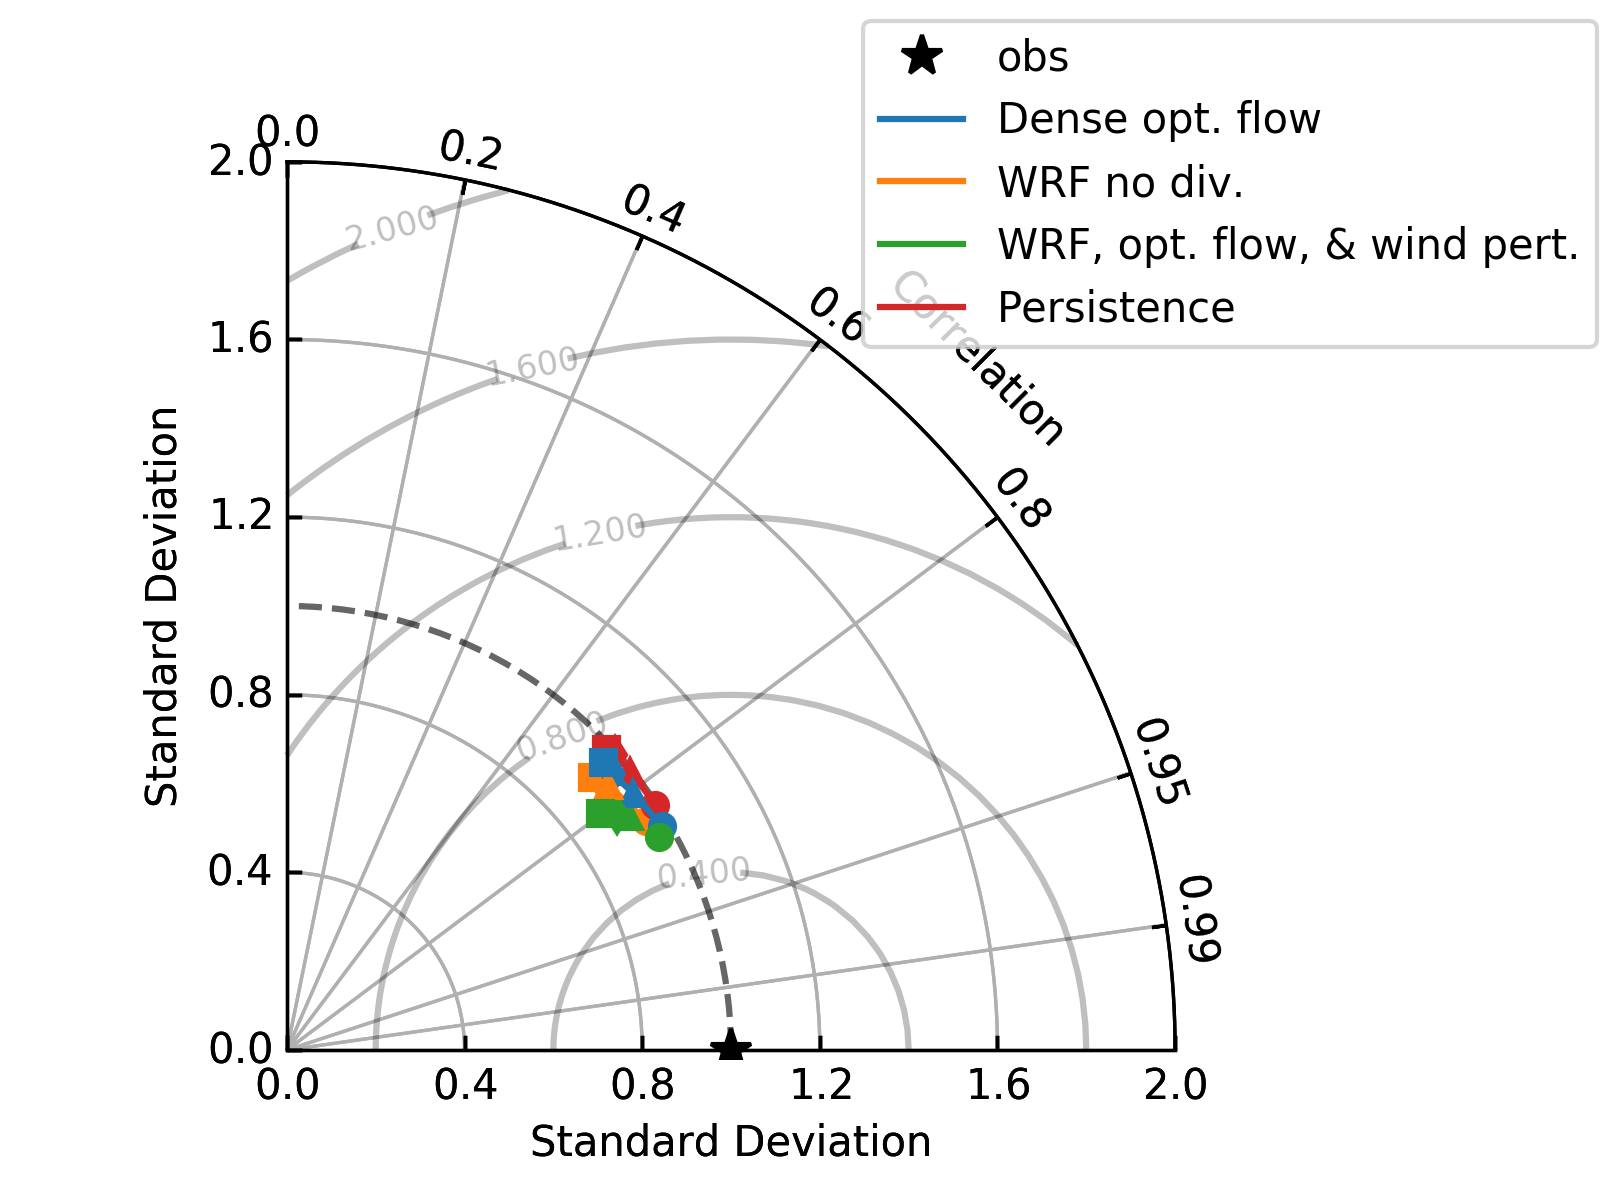

In [20]:
print(directory_name)
generate_taylor(error_stats, [legend_dict[arun] for arun in runs])

In [153]:
runs = ['opt_flow', 'wrf', 'wrf_no_div', 'ow_15', 'owp_opt', 'persistence']
# runs = ['opt_flow', 'wrf_no_div', 'owp_opt', 'persistence']

In [154]:
directory_name = 'third_set_only_cloudy'
error_stats = []
for run in runs:
    load_directory = ('/a2/uaren/travis/'
                      + 'results/multi_day_error/'
                      + f'{directory_name}/{run}')
    adict = {'name': run}
    for stat_file in os.listdir(load_directory):
        stat_name = stat_file.split('.')[0]
        stat_file = os.path.join(load_directory,
                                 stat_file)
        adict[stat_name] = pd.read_hdf(stat_file)
    error_stats.append(adict)

In [155]:
name_list = [
    arun['name']
    for arun in error_stats]
persistence = error_stats[
    name_list.index('persistence')]

In [156]:
stat='forecast_sd'
this_legend = []
print(stat)
print(directory_name)
plt.figure()
for these_errors in error_stats:
    print(these_errors['name'])
    print(these_errors['truth_sd'], '\n')
    print(these_errors[stat], '\n')
#     increase = (these_errors[stat].values
#                 - these_errors['truth_sd'].values)
#     percent_increase = increase/np.abs(these_errors['truth_sd']) * 100
#     this_legend.append(legend_dict[these_errors['name']])
#     plt.plot(percent_increase, linestyle='--', marker='.')

# increase = (persistence[stat].values
#             - persistence['truth_sd'].values)
# percent_increase = increase/np.abs(persistence['truth_sd'])
# this_legend.append(legend_dict['persistence'])
# plt.plot(percent_increase, linestyle='--', marker='.')

# plt.title('Percent increase in standard deviation')
# plt.ylabel('Percent increase in standard deviation')
# plt.xlabel('Time horizon (min)')
# plt.legend(this_legend)

forecast_sd
third_set_only_cloudy
opt_flow
     true_sd
0   0.245719
15  0.245516
30  0.243678
45  0.243072
60  0.240530 

          sd
0   0.245719
15  0.241631
30  0.236541
45  0.233736
60  0.231584 

wrf
     true_sd
0   0.245719
15  0.245516
30  0.243678
45  0.243072
60  0.240530 

          sd
0   0.245719
15  0.234021
30  0.226328
45  0.222270
60  0.215364 

wrf_no_div
     true_sd
0   0.245719
15  0.245516
30  0.243678
45  0.243072
60  0.240530 

          sd
0   0.245719
15  0.235517
30  0.228545
45  0.226601
60  0.221598 

ow_15
     true_sd
0   0.245719
15  0.245516
30  0.243678
45  0.243072
60  0.240530 

          sd
0   0.245719
15  0.237894
30  0.228925
45  0.224833
60  0.218482 

owp_opt
     true_sd
0   0.245719
15  0.245516
30  0.243678
45  0.243072
60  0.240530 

          sd
0   0.245719
15  0.237220
30  0.227674
45  0.222121
60  0.212753 

persistence
     true_sd
0   0.245719
15  0.245516
30  0.243678
45  0.243072
60  0.240530 

          sd
0   0.245719
15  0.2447

In [157]:
# improvements for rmse
stat='rmse'
print(stat)
print(directory_name)
for these_errors in error_stats:
    
    print(these_errors['name'] + '\n')
    
    print(these_errors[stat], '\n')
    
    if these_errors['name'] == 'persistence':
        continue
    print(these_errors['name'] + '\n')
    decrease = (persistence[stat]
                - these_errors[stat])
    percent_decrease = decrease/persistence[stat]
    print('Percent decrease')
    print(percent_decrease, '\n')
    skill_score = (1 - these_errors[stat]/persistence[stat]) * 100
    print('Skill Score')
    print(skill_score, '\n')

rmse
third_set_only_cloudy
opt_flow

            rmse
0   5.882707e-09
15  1.127897e-01
30  1.331196e-01
45  1.453242e-01
60  1.529031e-01 

opt_flow

Percent decrease
        rmse
0       -inf
15  0.205698
30  0.182283
45  0.163713
60  0.135094 

Skill Score
         rmse
0        -inf
15  20.569800
30  18.228335
45  16.371272
60  13.509393 

wrf

            rmse
0   5.882707e-09
15  1.180776e-01
30  1.439065e-01
45  1.508971e-01
60  1.546007e-01 

wrf

Percent decrease
        rmse
0       -inf
15  0.168459
30  0.116022
45  0.131643
60  0.125492 

Skill Score
         rmse
0        -inf
15  16.845893
30  11.602224
45  13.164304
60  12.549152 

wrf_no_div

            rmse
0   5.882707e-09
15  1.176884e-01
30  1.420766e-01
45  1.472657e-01
60  1.501500e-01 

wrf_no_div

Percent decrease
        rmse
0       -inf
15  0.171200
30  0.127263
45  0.152540
60  0.150667 

Skill Score
         rmse
0        -inf
15  17.119974
30  12.726310
45  15.254009
60  15.066737 

ow_15

            rms

In [158]:
# improvements for correlation
stat = 'correlation'
print(stat)
print(directory_name, '\n')

for these_errors in error_stats:
    print(these_errors['name'] + '\n')
    
    print(these_errors[stat], '\n')
    
    if these_errors['name'] == 'persistence':
        continue
    increase = (these_errors[stat]
                - persistence[stat])
    percent_increase = (increase/np.abs(persistence[stat])) * 100
    print('Percent increase')
    print(percent_increase, '\n')

correlation
third_set_only_cloudy 

opt_flow

    correlation
0      1.000000
15     0.858876
30     0.802699
45     0.764094
60     0.739169 

Percent increase
     correlation
0   1.110223e-14
15  3.192907e+00
30  3.394313e+00
45  2.762439e+00
60  1.550256e+00 

wrf

    correlation
0      1.000000
15     0.842228
30     0.764612
45     0.740621
60     0.726186 

Percent increase
     correlation
0   1.110223e-14
15  1.192759e+00
30 -1.511551e+00
45 -3.944500e-01
60 -2.333932e-01 

wrf_no_div

    correlation
0      1.000000
15     0.843832
30     0.771820
45     0.755930
60     0.746042 

Percent increase
     correlation
0   1.110223e-14
15  1.385454e+00
30 -5.830801e-01
45  1.664485e+00
60  2.494534e+00 

ow_15

    correlation
0      1.000000
15     0.856601
30     0.801378
45     0.779652
60     0.756839 

Percent increase
     correlation
0  -2.431388e-12
15  2.919633e+00
30  3.224243e+00
45  4.854782e+00
60  3.977937e+00 

owp_opt

    correlation
0      1.000000
15     0.8677

In [159]:
legend_dict = {'opt_flow': 'Dense opt. flow',
               'persistence': 'Persistence',
               'radiosonde': 'Radiosonde',
               'wrf': 'WRF',
               'wrf_no_div': 'WRF no div.',
               'ow_15': 'WRF & opt. flow',
               'owp_opt': 'WRF, opt. flow, & wind pert.'}

rmse
third_set_only_cloudy


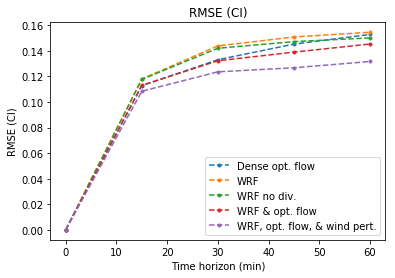

In [160]:
stat='rmse'
this_legend = []
print(stat)
print(directory_name)
plt.figure()
for these_errors in error_stats:
    if these_errors['name'] in ['persistence', 'radiosonde']:
        continue   
    this_legend.append(legend_dict[these_errors['name']])
    plt.plot(these_errors[stat], linestyle='--', marker='.')
plt.title('RMSE (CI)')
plt.ylabel('RMSE (CI)')
plt.xlabel('Time horizon (min)')
plt.legend(this_legend)
#     print('Percent decrease')
#     print(percent_decrease, '\n')

rmse
third_set_only_cloudy


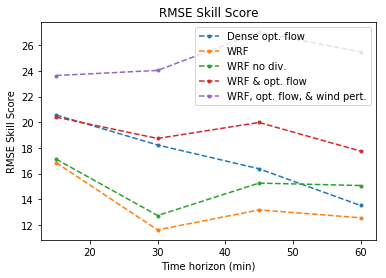

In [161]:
stat='rmse'
this_legend = []
print(stat)
print(directory_name)
plt.figure()
for these_errors in error_stats:
    if these_errors['name'] in ['persistence', 'radiosonde']:
        continue
    skill_score = (1 - these_errors[stat]/persistence[stat])*100    
    this_legend.append(legend_dict[these_errors['name']])
    plt.plot(skill_score, linestyle='--', marker='.')
plt.title('RMSE Skill Score')
plt.ylabel('RMSE Skill Score')
plt.xlabel('Time horizon (min)')
plt.legend(this_legend)
#     print('Percent decrease')
#     print(percent_decrease, '\n')

In [162]:
# stat='correlation'
# these_runs = []
# print(stat)
# print(directory_name)
# plt.figure()
# for these_errors in error_stats:
#     if these_errors['name'] == 'persistence':
#         continue
#     increase = (these_errors[stat]
#                 - persistence[stat])
#     percent_increase = increase/np.abs(persistence[stat])
#     these_runs.append(these_errors['name'])
#     plt.plot(percent_increase, linestyle='--', marker='.')
# plt.title('Percent increase of correlation (persistence as reference)')
# plt.ylabel('Correlation')
# plt.xlabel('Time horizon (min)')
# plt.legend(these_runs)
# #     print('Percent decrease')
# #     print(percent_decrease, '\n')

In [163]:
[this_errors['name'] for this_errors in error_stats]

['opt_flow', 'wrf', 'wrf_no_div', 'ow_15', 'owp_opt', 'persistence']

forecast_sd
third_set_only_cloudy


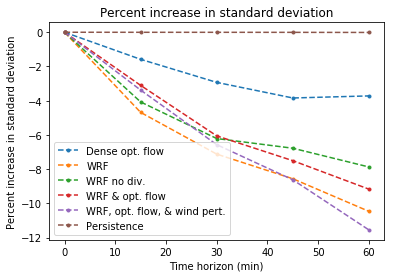

In [164]:
stat='forecast_sd'
this_legend = []
print(stat)
print(directory_name)
plt.figure()
for these_errors in error_stats:
    if these_errors['name'] in ['persistence', 'radiosonde']:
        continue
    increase = (these_errors[stat].values
                - these_errors['truth_sd'].values)
    percent_increase = increase/np.abs(these_errors['truth_sd']) * 100
    this_legend.append(legend_dict[these_errors['name']])
    plt.plot(percent_increase, linestyle='--', marker='.')

increase = (persistence[stat].values
            - persistence['truth_sd'].values)
percent_increase = increase/np.abs(persistence['truth_sd'])
this_legend.append(legend_dict['persistence'])
plt.plot(percent_increase, linestyle='--', marker='.')

plt.title('Percent increase in standard deviation')
plt.ylabel('Percent increase in standard deviation')
plt.xlabel('Time horizon (min)')
plt.legend(this_legend)

In [165]:
[legend_dict[arun] for arun in runs]

['Dense opt. flow',
 'WRF',
 'WRF no div.',
 'WRF & opt. flow',
 'WRF, opt. flow, & wind pert.',
 'Persistence']

third_set_only_cloudy
Reference std: 1


/home/travis/miniconda3/envs/letkf/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'fontsize'
  s)


(0.6, 1.1)

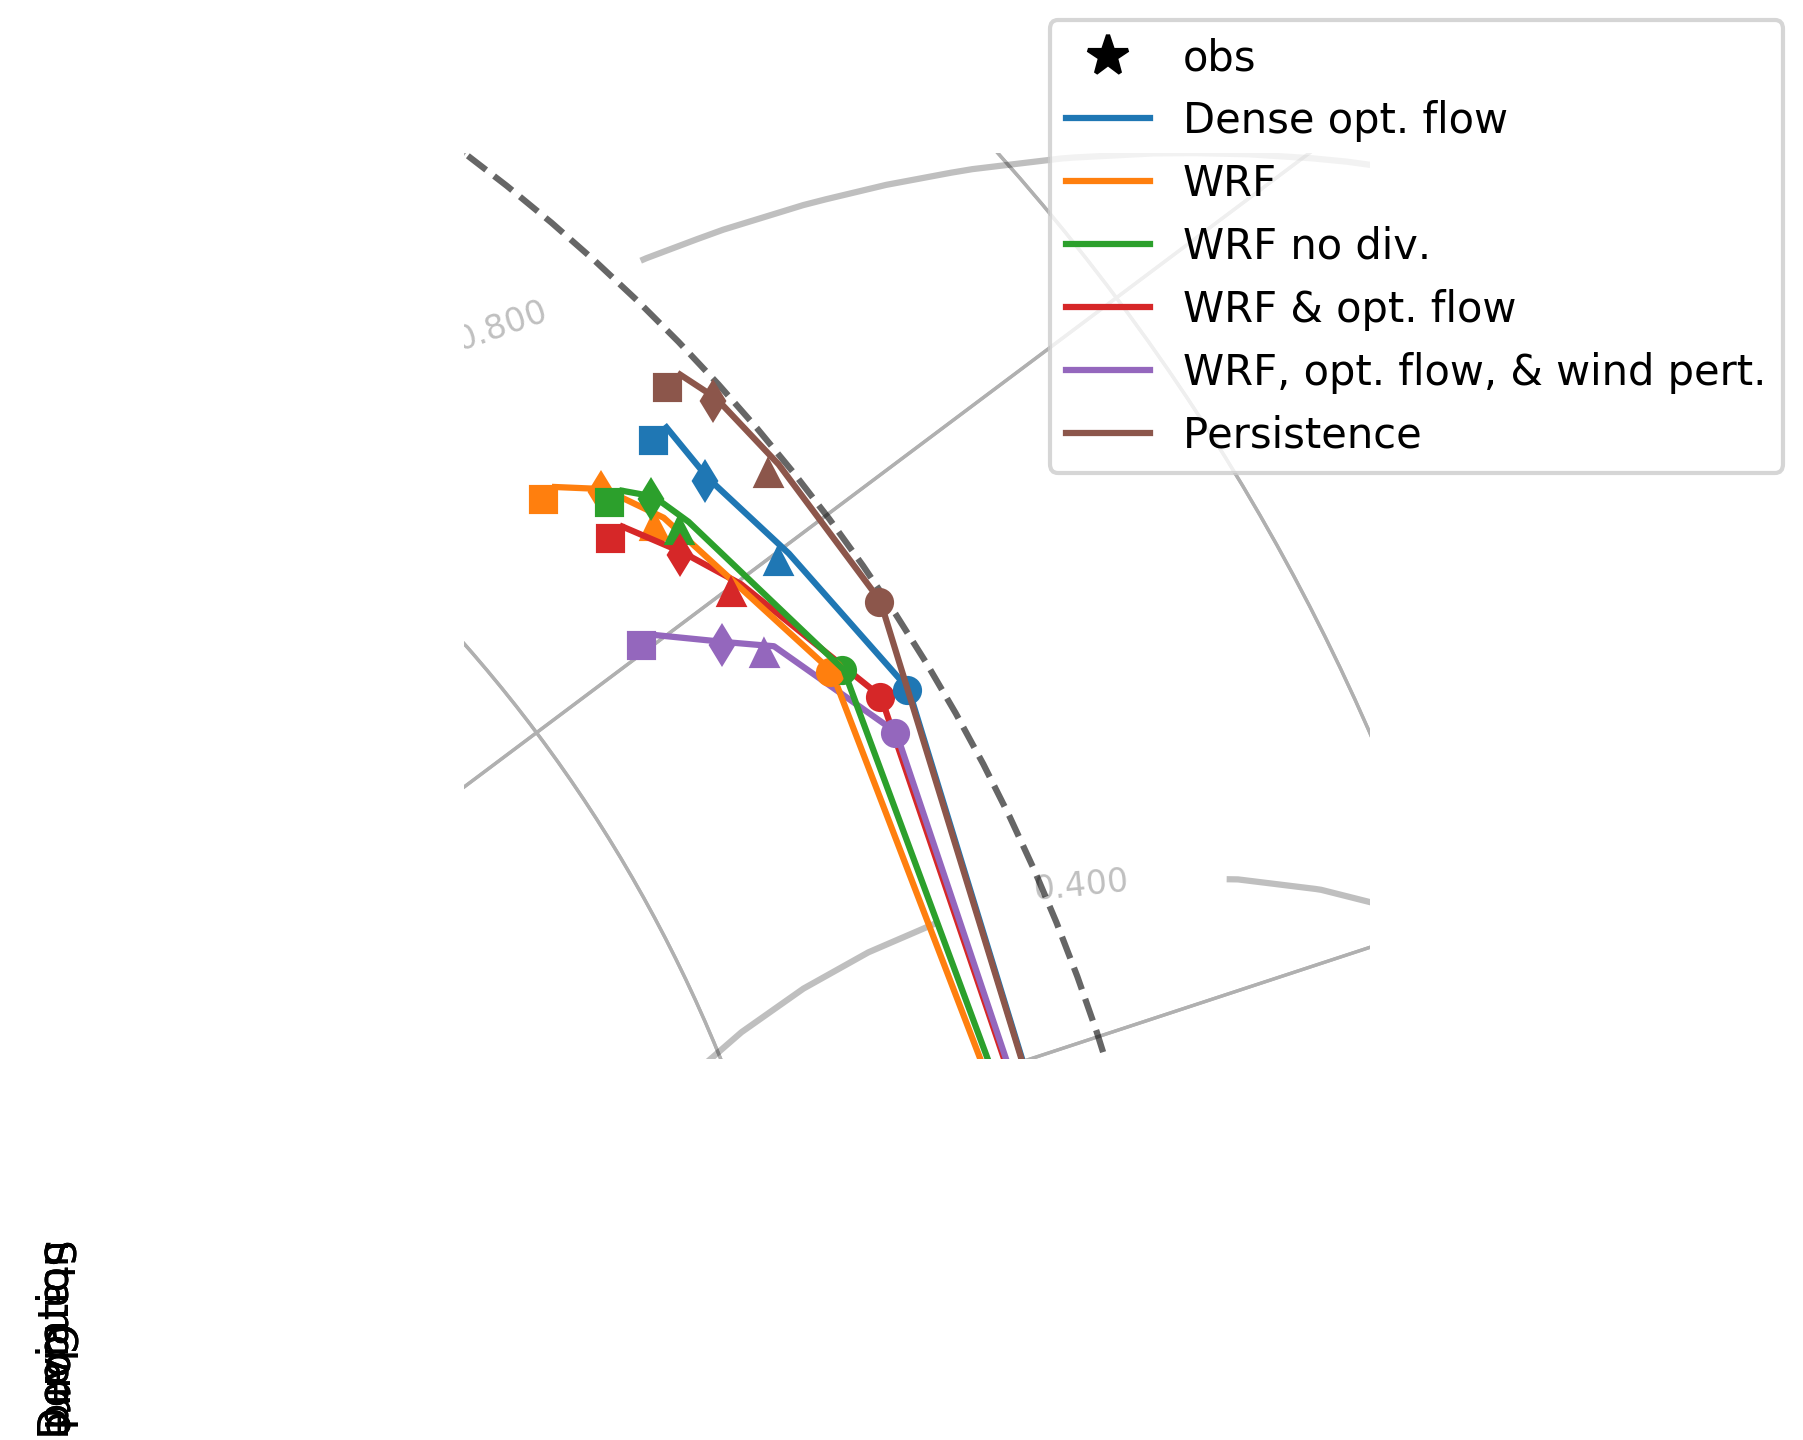

In [166]:
print(directory_name)
# this_error_stats = [e]
generate_taylor(error_stats, [legend_dict[arun] for arun in runs])
plt.ylim([.3, .8])
plt.xlim([.6, 1.1])

third_set_only_cloudy
Reference std: 1


/home/travis/miniconda3/envs/letkf/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'fontsize'
  s)


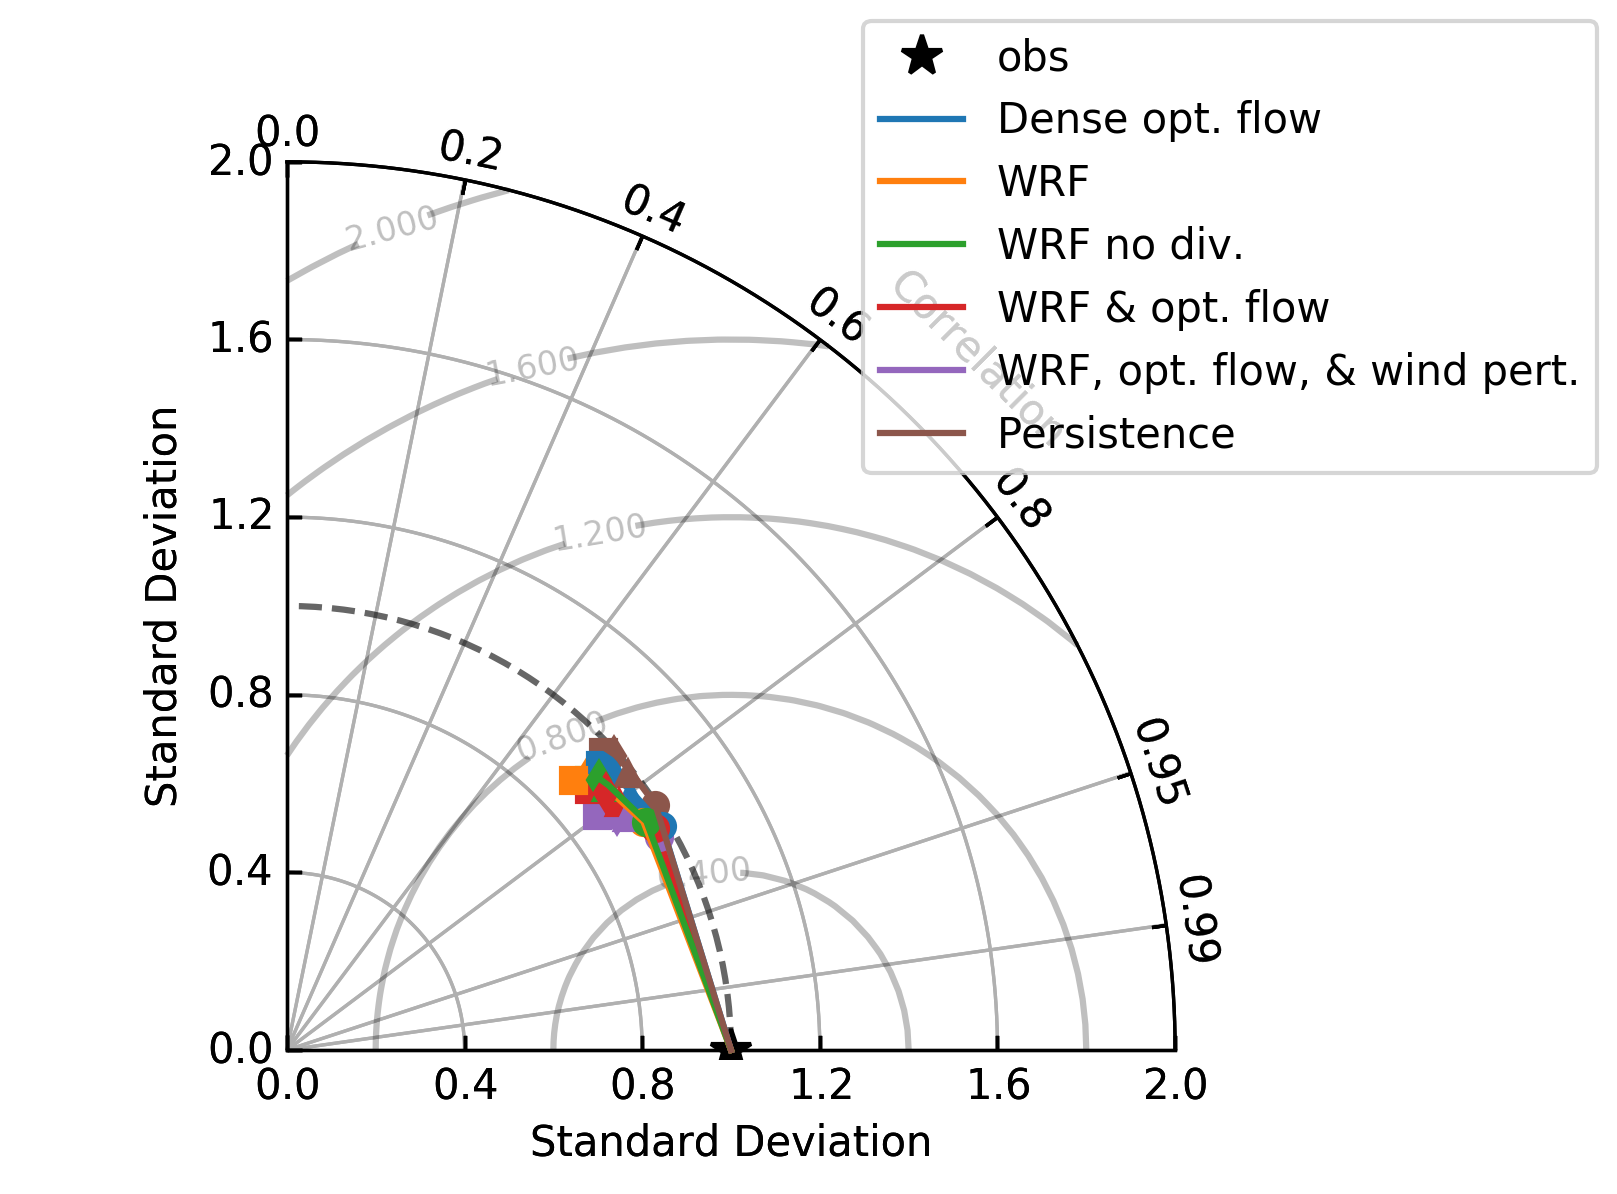

In [167]:
print(directory_name)
generate_taylor(error_stats, [legend_dict[arun] for arun in runs])